State dim: 4, Action dim: 2, Hidden dim: 32
Threshold: 475.0
Episode    0 | Score:  24.0 | Avg: 24.00 | eps: 1.00 | Updates: 0 | Time: 00:00:00
Episode   10 | Score:  11.0 | Avg: 21.73 | eps: 0.82 | Updates: 44 | Time: 00:00:00
Episode   20 | Score:  13.0 | Avg: 18.43 | eps: 0.67 | Updates: 81 | Time: 00:00:00
Episode   30 | Score:  27.0 | Avg: 19.35 | eps: 0.55 | Updates: 135 | Time: 00:00:00
Episode   40 | Score:  18.0 | Avg: 17.90 | eps: 0.45 | Updates: 168 | Time: 00:00:00
Episode   50 | Score:  13.0 | Avg: 17.22 | eps: 0.36 | Updates: 204 | Time: 00:00:01
Episode   60 | Score:  12.0 | Avg: 16.56 | eps: 0.30 | Updates: 237 | Time: 00:00:01
Episode   70 | Score:  15.0 | Avg: 16.18 | eps: 0.24 | Updates: 272 | Time: 00:00:01
Episode   80 | Score:  10.0 | Avg: 15.74 | eps: 0.20 | Updates: 303 | Time: 00:00:01
Episode   90 | Score:  13.0 | Avg: 15.33 | eps: 0.16 | Updates: 333 | Time: 00:00:01
Episode  100 | Score:  14.0 | Avg: 16.07 | eps: 0.13 | Updates: 392 | Time: 00:00:02
Episode 

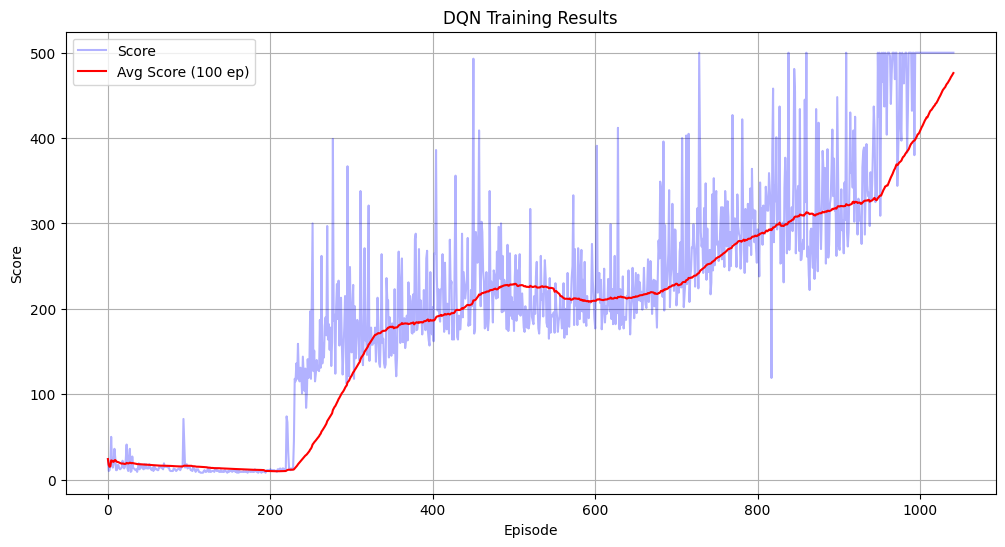

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import time
from collections import deque, namedtuple

np.bool8 = np.bool_

# Setup
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Config
BATCH_SIZE = 64  
TAU = 0.005       # Параметр мягкого обновления целевой сети
GAMMA = 0.99
LR = 0.001
NUM_EPISODES = 2000
PRINT_EVERY = 10
HIDDEN_DIM = 32   # Возвращаемся к меньшему размеру сети
MIN_EPS = 0.01
MAX_EPS_EPISODE = 100

# Epsilon schedule - экспоненциальный анилинг
def epsilon_annealing(i_episode):
    decay = 0.98  # Слегка замедленный распад
    return max(MIN_EPS, (decay ** i_episode))

# Transition tuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

# Стандартный буфер воспроизведения
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Упрощенная Q-Network архитектура
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Agent с мягким обновлением
class Agent:
    def __init__(self, n_states, n_actions, hidden_dim):
        self.q_local = QNetwork(n_states, n_actions, hidden_dim).to(device)
        self.q_target = QNetwork(n_states, n_actions, hidden_dim).to(device)
        self.q_target.load_state_dict(self.q_local.state_dict())

        self.optimizer = optim.Adam(self.q_local.parameters(), lr=LR)
        self.loss_fn = nn.MSELoss()
        self.replay_memory = ReplayMemory(10000)
        self.n_actions = n_actions
        self.t_step = 0
        self.batch_updates = 0

    def get_action(self, state, eps):
        if random.random() > eps:
            with torch.no_grad():
                return self.q_local(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

    def learn(self):
        # Обновляем сеть каждые 4 шага для эффективности (как в оригинальной работе DeepMind)
        self.t_step = (self.t_step + 1) % 4
        if self.t_step != 0:
            return
            
        if len(self.replay_memory) < BATCH_SIZE:
            return
        
        transitions = self.replay_memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)
        next_states = torch.cat(batch.next_state)
        dones = torch.cat(batch.done)

        # Вычисление TD-ошибки
        q_expected = self.q_local(states).gather(1, actions)
        with torch.no_grad():
            q_next = self.q_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_target = rewards + (GAMMA * q_next * (1 - dones))
        
        # Функция потерь и оптимизация
        loss = self.loss_fn(q_expected, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        # Клиппинг градиентов для стабильности
        torch.nn.utils.clip_grad_norm_(self.q_local.parameters(), 1.0)
        self.optimizer.step()
        
        # Мягкое обновление целевой сети после каждого обучения
        self.soft_update()
        self.batch_updates += 1
            
    # Мягкое обновление целевой сети
    def soft_update(self):
        for target_param, local_param in zip(self.q_target.parameters(), self.q_local.parameters()):
            target_param.data.copy_(TAU * local_param.data + (1.0 - TAU) * target_param.data)

# Training one episode
def run_episode(env, agent, eps):
    state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()
    state = torch.FloatTensor([state]).to(device)
    total_reward = 0
    done = False

    while not done:
        action = agent.get_action(state, eps)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        total_reward += reward
        reward = -10.0 if done and total_reward < env.spec.reward_threshold else reward  # Увеличенный штраф при неудаче
            
        next_state = torch.FloatTensor([next_state]).to(device)
        reward = torch.FloatTensor([reward]).unsqueeze(0).to(device)
        done = torch.FloatTensor([float(done)]).unsqueeze(0).to(device)

        agent.replay_memory.push(state, action, reward, next_state, done)
        state = next_state
        agent.learn()

    return total_reward

# Main training loop
def train(agent, env):
    scores = []
    avg_scores = []
    scores_deque = deque(maxlen=100)
    threshold = env.spec.reward_threshold
    
    start_time = time.time()

    for i_episode in range(NUM_EPISODES):
        eps = epsilon_annealing(i_episode)
        score = run_episode(env, agent, eps)

        scores.append(score)
        scores_deque.append(score)
        avg_score = np.mean(scores_deque)
        avg_scores.append(avg_score)

        if i_episode % PRINT_EVERY == 0:
            dt = int(time.time() - start_time)
            print(f"Episode {i_episode:4d} | Score: {score:5.1f} | Avg: {avg_score:5.2f} | eps: {eps:.2f} | Updates: {agent.batch_updates} | Time: {dt//3600:02}:{dt%3600//60:02}:{dt%60:02}")

        if avg_score >= threshold and len(scores_deque) == scores_deque.maxlen:
            print(f"\nEnvironment solved in {i_episode} episodes! Average Score: {avg_score:.2f}")
            torch.save(agent.q_local.state_dict(), f"dqn_cartpole_simplified.pth")
            break

    # Визуализация результатов обучения
    plt.figure(figsize=(12, 6))
    plt.plot(scores, 'b-', alpha=0.3, label='Score')
    plt.plot(avg_scores, 'r-', label='Avg Score (100 ep)')
    plt.title('DQN Training Results')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.savefig('dqn_training_results_simplified.png')
    plt.show()
    
    return scores, avg_scores

# Start training
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"State dim: {state_dim}, Action dim: {action_dim}, Hidden dim: {HIDDEN_DIM}")
print(f"Threshold: {env.spec.reward_threshold}")

agent = Agent(state_dim, action_dim, HIDDEN_DIM)
scores, avg_scores = train(agent, env)